In [1]:
import sys
sys.path.append('../source_code/')
import dataset as dataset
import biDAF_pytorch as biDAF_pytorch
import pandas as pd
import os, copy
import json
import nltk
import torch
from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe
import time
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
import numpy as np
import utils as utils
import pytorch_utils as pytorch_utils
from pympler import asizeof
%load_ext autoreload
%autoreload 2

### Pytorch section

In [2]:
#colours for coloured print
CRED = '\033[91m'
CEND = '\033[0m'

- As a first step we should choose a device: if cuda is available we choose it, otherwise we will use cpu

In [4]:
device = pytorch_utils.get_device(force_cpu = True)

Found device: cuda
GeForce GTX TITAN X
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Found device: cpu
CPU cores count: 20
Using device: cpu
sys version: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


- Print available GPU memory

In [5]:
pytorch_utils.get_gpu_memory_usage()

CPU has 492.0Mb free, 11718.0Mb used


- Here is setup parameters of our training process

In [6]:
batch_size = 32
#a dimension of word embedding vector
word_dim = 300

- We will use class DataSet for batch generation

In [16]:
start_time = time.time()
squad_data = dataset.DataSet("../data/squad/dev-v2.0.json", "", batch_size, device, word_dim)
print("Time of dataSet and batches creation. Time: {} sec.".format(round(time.time()-start_time, 2))) 

building splits...
building vocab...
building iterators...
Time of dataSet and batches creation. Time: 2.14 sec.


- Print training dataset

In [17]:
squad_data.print_train_data()

(0, {'id': '56ddde6b9a695914005b9628', 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.', 'question': 'In what country is Normandy located?', 'answer': 'France', 's_idx': 34, 'e_idx': 34})
(1, {'id': '56ddde6b9a695914005b9628', 'context': 'The Normans (Norman: Nourmands; French: Normands; Lati

In [18]:
print('size of train data: {0}kb'.format(asizeof.asizeof(squad_data) / 1024))

size of train data: 749.046875kb


- For QA on SQuAD dataset we use BiDAF model

In [19]:
model = biDAF_pytorch.BiDAF(squad_data.WORD.vocab.vectors, word_dim).to(device)
print("BiDAF model internal structure: {0}".format(model))

BiDAF model internal structure: BiDAF(
  (word_emb): Embedding(251, 300)
  (context_LSTM): LSTM(
    (rnn): LSTM(300, 300, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2)
  )
  (att_weight_c): Linear(
    (linear): Linear(in_features=600, out_features=1, bias=True)
  )
  (att_weight_q): Linear(
    (linear): Linear(in_features=600, out_features=1, bias=True)
  )
  (att_weight_cq): Linear(
    (linear): Linear(in_features=600, out_features=1, bias=True)
  )
  (modeling_LSTM): LSTM(
    (rnn): LSTM(2400, 300, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2)
  )
  (p1_weight_g): Linear(
    (linear): Linear(in_features=2400, out_features=1, bias=True)
    (dropout): Dropout(p=0.2)
  )
  (p1_weight_m): Linear(
    (linear): Linear(in_features=600, out_features=1, bias=True)
    (dropout): Dropout(p=0.2)
  )
  (p2_weight_g): Linear(
    (linear): Linear(in_features=2400, out_features=1, bias=True)
    (dropout): Dropout(p=0.2)
  )
  (p2_weight_m): Line

In [20]:
print('size of biDAF model: {0}kb'.format(asizeof.asizeof(model) / 1024))

size of biDAF model: 110.640625kb


- Print word embedding vector for separate word from dictionary before training

In [21]:
squad_data.print_vocab_by_number(2)

for word 'the' we have 300 embedding vector: tensor([-2.0838e-01, -1.4932e-01, -1.7528e-02, -2.8432e-02, -6.0104e-02,
        -2.6460e-01, -4.1445e+00,  6.2932e-01,  3.3672e-01, -4.3395e-01,
         3.9899e-01, -1.9573e-01,  1.3977e-01, -2.1519e-02,  3.7823e-01,
        -5.5250e-01, -1.1230e-01, -8.1443e-03,  2.9059e-01,  6.6817e-02,
         1.0465e-01, -8.6943e-02, -4.8983e-02, -2.6757e-01, -4.7038e-01,
         2.7469e-01,  6.9245e-02, -2.7967e-02, -1.9719e-01,  1.6749e-02,
        -2.9681e-01,  1.7838e-01,  5.8374e-02, -2.4806e-01,  8.5846e-02,
         3.5043e-01,  4.9157e-02, -1.6431e-01,  5.0012e-01, -1.8053e-01,
         3.1422e-01,  1.0671e-01,  3.1852e-02,  7.4278e-02,  2.7956e-01,
         8.0317e-02,  5.4780e-02, -3.0349e-01, -4.3215e-01,  3.2417e-01,
         4.0856e-01,  3.6192e-01,  1.3445e-01, -1.2933e-01,  1.1331e-01,
        -1.5755e-01,  3.5755e-01,  3.0463e-01, -9.8488e-02,  1.2032e-02,
         4.5581e-01,  3.7101e-01,  1.4270e-01, -4.3329e-01, -1.0869e-01,
      

In [22]:
def train(model, training_data, device, epochs, learning_rate, exp_decay_rate, word_dim):    
    ema = biDAF_pytorch.EMA(exp_decay_rate)
    for name, param in model.named_parameters():
        if param.requires_grad:
            ema.register(name, param.data)
    
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adadelta(parameters, lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    #tells your model that you are training the model. 
    #So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures 
    #know what is going on and hence can behave accordingly.
    model.train()

    ave_grads = {}
    std_grads = {}
    max_grad = 0
    loss = 0
    train_iter = training_data.train_iter
    train_iter.repeat = False
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            ave_grads[param] = []
            std_grads[param] = []
    
    for epoch in range(epochs):
        train_iter.init_epoch()
        loss = 0
        for i, batch in enumerate(train_iter):
            p1, p2 = model(batch)

            optimizer.zero_grad()
            batch_loss = criterion(p1, batch.s_idx) + criterion(p2, batch.e_idx)
            loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()

            for name, param in model.named_parameters():
                if param.requires_grad:
                    ema.update(name, param.data)
         
        max_grad = pytorch_utils.plot_grad_flow_add_epoch(model.named_parameters(), ave_grads, std_grads, max_grad)
        loss /= len(train_iter)
        print(CRED + 'epoch {0}, iter {1}: mean loss {2}'.format(epoch, i, loss) + CEND)
        pytorch_utils.cpuStats()
    
    pytorch_utils.plot_grad_flow(model.named_parameters(), range(epochs), ave_grads, std_grads, max_grad)
    best_model = copy.deepcopy(model)
    return best_model

- Perform training of biDAF model on SQuAD dataset (we take only 12 training examples in order to speed up training)

epoch 0, iter 0: mean loss 11.05908203125
{'pid': 14675, 'run on cpu': 5, 'percent_cpu_used': 1.0, 'percent_physical system memory_used': 2.4583759014646267}
epoch 1, iter 0: mean loss 9.823034286499023
{'pid': 14675, 'run on cpu': 6, 'percent_cpu_used': 0.0, 'percent_physical system memory_used': 2.567515446251556}
epoch 2, iter 0: mean loss 9.203865051269531
{'pid': 14675, 'run on cpu': 14, 'percent_cpu_used': 0.0, 'percent_physical system memory_used': 2.5670394633483764}
epoch 3, iter 0: mean loss 8.467251777648926
{'pid': 14675, 'run on cpu': 13, 'percent_cpu_used': 0.0, 'percent_physical system memory_used': 2.568534110299124}
epoch 4, iter 0: mean loss 7.763036251068115
{'pid': 14675, 'run on cpu': 8, 'percent_cpu_used': 1.0, 'percent_physical system memory_used': 2.6670837934248754}
epoch 5, iter 0: mean loss 7.254136085510254
{'pid': 14675, 'run on cpu': 8, 'percent_cpu_used': 1.0, 'percent_physical system memory_used': 2.7948836870593707}
epoch 6, iter 0: mean loss 6.69073772

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


Done. Time: 1247.78 sec.


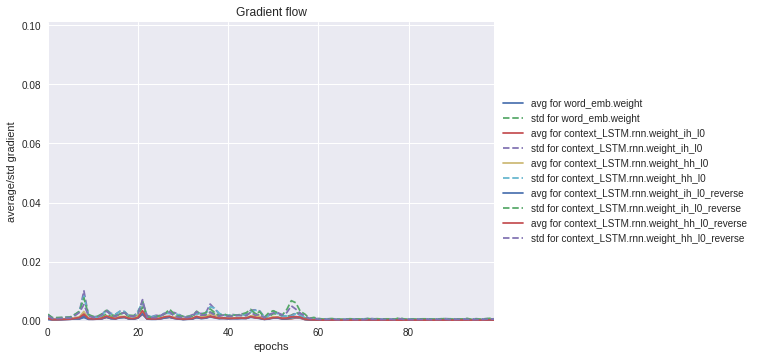

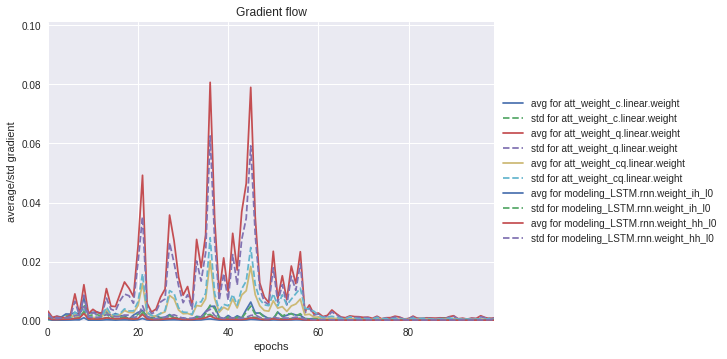

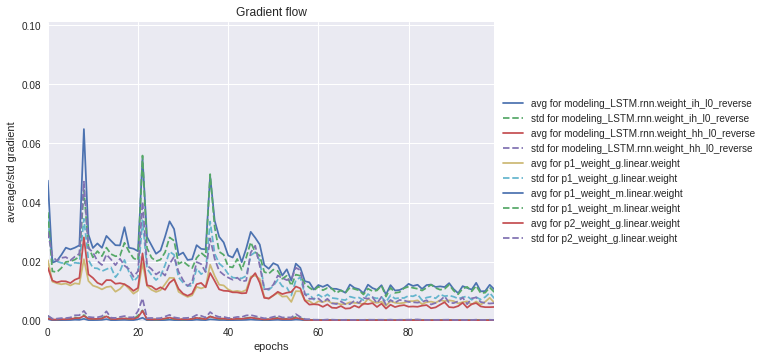

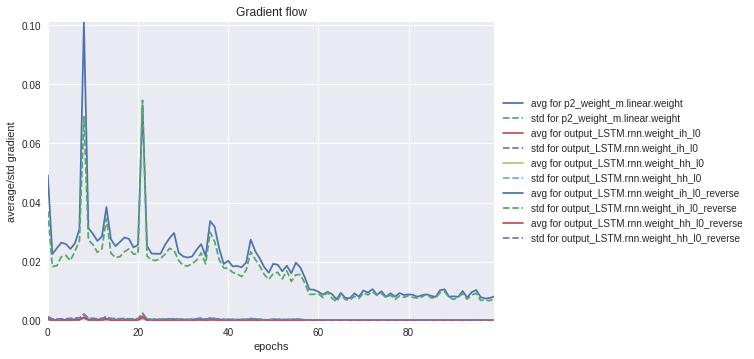

<Figure size 576x396 with 0 Axes>

In [23]:
start_time = time.time()
trained_model = train(model, squad_data, device, epochs = 100, learning_rate = 0.5, exp_decay_rate = 0.999, word_dim = word_dim)
print("Done. Time: {} sec.".format(round(time.time()-start_time, 2)))

- Print word embedding vector for separate word from dictionary after training (we can see that word embedding vector has changed)

In [24]:
squad_data.print_vocab_by_number(2)

for word 'the' we have 300 embedding vector: tensor([-1.9809e-01, -1.6242e-01,  2.1084e-02, -3.2240e-02, -3.9287e-02,
        -2.5200e-01, -4.1076e+00,  6.1368e-01,  3.6657e-01, -4.4781e-01,
         4.0054e-01, -2.1427e-01,  1.4219e-01, -1.2783e-02,  3.6114e-01,
        -5.6765e-01, -1.0249e-01,  1.5975e-03,  2.9258e-01,  7.2506e-02,
         1.1667e-01, -7.6212e-02, -7.1301e-02, -2.6478e-01, -5.0603e-01,
         2.9598e-01,  7.9377e-02, -5.2708e-03, -1.9012e-01,  2.6271e-02,
        -3.0635e-01,  2.0861e-01,  7.2113e-02, -2.2273e-01,  8.9379e-02,
         3.6153e-01,  3.3619e-02, -1.5808e-01,  5.1676e-01, -1.9309e-01,
         3.2373e-01,  1.0372e-01,  4.3809e-02,  1.0352e-01,  2.7848e-01,
         7.5223e-02,  2.9616e-02, -2.9114e-01, -4.8341e-01,  3.3597e-01,
         4.2079e-01,  3.7210e-01,  1.7128e-01, -1.2645e-01,  8.0152e-02,
        -1.3736e-01,  3.7465e-01,  3.3154e-01, -1.0524e-01,  1.8005e-02,
         4.7742e-01,  3.9798e-01,  1.2437e-01, -4.5705e-01, -9.6672e-02,
      

In [25]:
def test(model, prediction_file, data, device):
    criterion = nn.CrossEntropyLoss()
    loss = 0
    answers = dict()
    model.eval()

    f1_scores = []
    em_scores = []
    for batch in iter(data.dev_iter):       
        p1, p2 = model(batch)

        batch_size, c_len = p1.size()
        ls = nn.LogSoftmax(dim=1)
        mask = (torch.ones(c_len, c_len) * float('-inf')).to(device).tril(-1).unsqueeze(0).expand(batch_size, -1, -1)
        score = (ls(p1).unsqueeze(2) + ls(p2).unsqueeze(1)) + mask
        score, s_idx = score.max(dim=1)
        score, e_idx = score.max(dim=1)
        s_idx = torch.gather(s_idx, 1, e_idx.view(-1, 1)).squeeze()

        for i in range(batch_size):
            answer = batch.c_word[0][i][s_idx[i]:e_idx[i] + 1]
            answer = ' '.join([data.WORD.vocab.itos[idx] for idx in answer])
            
            answer_need = batch.c_word[0][i][batch.s_idx[i]:batch.e_idx[i] + 1]
            answer_need = ' '.join([data.WORD.vocab.itos[idx] for idx in answer_need])
           
            question = batch.q_word[0][i]
            question = ' '.join([data.WORD.vocab.itos[idx] for idx in question]).replace('<pad>', '')
            print('question: {0}'.format(question))
            print('get answer: {0}, need answer: {1}'.format(answer, answer_need))
            
            f1_scores.append(utils.f1_score(answer, answer_need))
            em_scores.append(utils.exact_match_score(answer, answer_need))
            
    f1_score = np.mean(f1_scores)
    em_score = np.mean(em_scores)
    
    print("scores: f1 {0}, em {1}".format(f1_score, em_score))

- Perform test under trained model

In [26]:
test(trained_model, "../data/squad/pred.json", squad_data, device)      

question: What religion were the Normans      
get answer: Catholic, need answer: Catholic
question: What religion were the Normans      
get answer: Catholic, need answer: Catholic orthodoxy
question: What religion were the Normans      
get answer: Catholic, need answer: Catholic
question: Who ruled the duchy of Normandy     
get answer: Richard I, need answer: Richard I
question: Who ruled the duchy of Normandy     
get answer: Richard I, need answer: Richard I
question: Who ruled the duchy of Normandy     
get answer: Richard I, need answer: Richard I
question: Who was the duke in the battle of Hastings ? 
get answer: William the Conqueror, need answer: William the Conqueror
question: Who was the duke in the battle of Hastings ? 
get answer: William the Conqueror, need answer: William the Conqueror
question: Who was the duke in the battle of Hastings ? 
get answer: William the Conqueror, need answer: William the Conqueror
question: What century did the Normans first gain their sepa

### Tensorflow section

In [27]:
import tensorflow as tf
from tensorflow.python.client import device_lib

In [28]:
tf.test.is_gpu_available()

False

In [29]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4144703285061332987, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2780143274567968803
 physical_device_desc: "device: XLA_CPU device"]